In [11]:
from pprint import pprint
from typing import List

import numpy as np
import pandas as pd

from src.utilities.constants import (
    LYS_BONDS,
    LIP_BONDS,
    OVA_BONDS,
    BSA_BONDS,
    LYS,
    LIP,
    BSA,
    OVA,
)
from src.model.fragment import Fragment
from src.model.precursor import Precursor
from src.utilities.dataloading import load_fragment_matches, load_precursor_matches
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx

import itertools

from src.model.variant import Variant

PROTEIN = "TEST_OVA"
SEGMENTS = 3
BREAKS = 2

KIND = "AT"
ERROR = 5
CODE = None

# Visualising
CMAP = plt.get_cmap("PiYG")
CYSTEINES = []
TRUE_BONDS = []


def get_cysteines(sequence):
    return [i for i, res in enumerate(sequence) if res == "C"]


if PROTEIN == "LYS":
    CYSTEINES = get_cysteines(LYS)
    TRUE_BONDS = LYS_BONDS
elif PROTEIN == "LIP":
    CYSTEINES = get_cysteines(LIP)
    TRUE_BONDS = LIP_BONDS
elif PROTEIN == "OVA" or PROTEIN == "TEST_OVA":
    CYSTEINES = get_cysteines(OVA)
    TRUE_BONDS = OVA_BONDS
elif PROTEIN == "BSA":
    CYSTEINES = get_cysteines(BSA)
    TRUE_BONDS = BSA_BONDS

CYSTEINES

[10, 29, 72, 119, 366, 381]

In [12]:
precursor_matches = load_precursor_matches(
    protein=PROTEIN, kind=KIND, segments=SEGMENTS, error=ERROR, code=CODE
)
precursor_matches[:2]

Loading precursors from ../out/precursor_matches/TEST_OVA_AT_segments=3_error=5ppm.pickle...


[{'scan': <src.model.scan.Scan at 0x10b1eb220>,
  'precursor': Precursor(sequence='YNLTSVLMAMGITDVFSSSANLSGISSAESLK', mass=3295.6441707145195, mz=1098.54805690484, segments=[(28, 29)], residue_ranges=[(290, 322)], cys_bond_count=0, alkylation_count=0, modifications=[], error_ppm=0.0)},
 {'scan': <src.model.scan.Scan at 0x10b1c9b20>,
  'precursor': Precursor(sequence='VYLPRMKMEEK', mass=1423.7441530408103, mz=1423.7441530408103, segments=[(25, 28)], residue_ranges=[(279, 290)], cys_bond_count=0, alkylation_count=0, modifications=[], error_ppm=1.5981434575545277e-10)}]

In [13]:
fragment_matches = load_fragment_matches(
    protein=PROTEIN, kind=KIND, segments=SEGMENTS, breaks=BREAKS, error=ERROR, code=CODE
)
fragment_matches[:3]

Loading fragments from ../out/fragment_matches/TEST_OVA_AT_segments=3_breaks=2_error=5ppm.pickle


[{'scan': <src.model.scan.Scan at 0x11faddca0>,
  'precursor': Precursor(sequence='NVLQPSSVDSQTAMVLVNAIVFKGLWEK', mass=3074.6474428498504, mz=1537.3237214249252, segments=[(14, 16)], residue_ranges=[(158, 186)], cys_bond_count=0, alkylation_count=0, modifications=[], error_ppm=0.0),
  'variant': <src.model.variant.Variant at 0x1210e3910>,
  'variant_count': 1,
  'fragment': Fragment(id=0, sequence='N', residue_ranges=[(158, 159)], intensity=10, intensity_ratio=0.025, mass=115.05075247321001, target_mass=114.042378876189, mz=115.05075247321001, target_mz=115.05020390825901, charge=1, break_count=1, error_ppm=4.810161956660165, modifications=(), connected_bonds=[], disconnected_cys=[])},
 {'scan': <src.model.scan.Scan at 0x11faddca0>,
  'precursor': Precursor(sequence='NVLQPSSVDSQTAMVLVNAIVFKGLWEK', mass=3074.6474428498504, mz=1537.3237214249252, segments=[(14, 16)], residue_ranges=[(158, 186)], cys_bond_count=0, alkylation_count=0, modifications=[], error_ppm=0.0),
  'variant': <src.mod

In [14]:

def var_is_good(fragment_match):
    v: Variant = fragment_match["variant"]
    bond_cys = set(c for b in TRUE_BONDS for c in b)
    seen_cys = False

    for c in CYSTEINES:
        if v[c] is not None:
            has_partner = (partner := v.bond_partner(c)) is not None
            bad_bond = has_partner and c < partner and (c, partner) not in TRUE_BONDS
            bad_alkylation = not has_partner and c in bond_cys
            if bad_bond or bad_alkylation:
                return False
            seen_cys = True

    if seen_cys:
        return True


records = [
    fm["scan"].to_dict()
    | fm["precursor"].to_dict()
    | fm["variant"].to_dict()
    | (fm["fragment"].to_dict() if fm["fragment"] is not None else {})
    | {"prec_variant_count": fm["variant_count"], "var_is_good": var_is_good(fm)}
    for fm in fragment_matches
]

records[:3]

[{'scan_id': 0,
  'scan_nth_in_order': 0,
  'scan_time': 0,
  'scan_total_intensity': 400,
  'prec_charge': 2,
  'prec_sequence': 'NVLQPSSVDSQTAMVLVNAIVFKGLWEK',
  'prec_segment_count': 1,
  'prec_tryptide_ranges': [(14, 16)],
  'prec_residue_ranges': [(158, 186)],
  'prec_max_mc_count': 1,
  'prec_mc': [1],
  'prec_cys_bond_count': 0,
  'prec_mass': 3074.6474428498504,
  'prec_mz': 1537.3237214249252,
  'prec_error': 0.0,
  'prec_alkylation_count': 0,
  'prec_mods': [],
  'var_bonds': [],
  'frag_id': 0,
  'frag_sequence': 'N',
  'frag_residue_ranges': [(158, 159)],
  'frag_charge': 1,
  'frag_mass': 115.05075247321001,
  'frag_mz': 115.05075247321001,
  'frag_break_count': 1,
  'frag_error_ppm': 4.810161956660165,
  'frag_mods': [],
  'frag_connected_bonds': [],
  'frag_disconnected_cys': [],
  'frag_interesting_disconnected_cys': [],
  'frag_intensity': 10,
  'frag_intensity_ratio': 0.025,
  'target_mass': 114.042378876189,
  'target_mz': 115.05020390825901,
  'prec_variant_count': 

In [15]:
df = pd.DataFrame(records)


def stringify(df, column):
    res = []
    for rs in df[column]:
        res.append(" + ".join([str(r) for r in rs]) if rs is not np.nan else pd.NA)
    df[column] = res


for c in [
    "prec_tryptide_ranges",
    "prec_residue_ranges",
    "prec_mods",
    "prec_mc",
    "var_bonds",
    "frag_residue_ranges",
    "frag_mods",
    "frag_connected_bonds",
    "frag_disconnected_cys",
    "frag_interesting_disconnected_cys",
]:
    stringify(df, c)

df

,scan_id,scan_nth_in_order,scan_time,scan_total_intensity,prec_charge,prec_sequence,prec_segment_count,prec_tryptide_ranges,prec_residue_ranges,prec_max_mc_count,...,frag_mods,frag_connected_bonds,frag_disconnected_cys,frag_interesting_disconnected_cys,frag_intensity,frag_intensity_ratio,target_mass,target_mz,prec_variant_count,var_is_good
0,0,0,0,400,2,NVLQPSSVDSQTAMVLVNAIVFKGLWEK,1,"(14, 16)","(158, 186)",1,...,,,,,10,0.025000,114.042379,115.050204,1,None
1,0,0,0,400,2,NVLQPSSVDSQTAMVLVNAIVFKGLWEK,1,"(14, 16)","(158, 186)",1,...,,,,,10,0.025000,326.194857,327.202682,1,None
2,0,0,0,400,2,NVLQPSSVDSQTAMVLVNAIVFKGLWEK,1,"(14, 16)","(158, 186)",1,...,,,,,10,0.025000,551.305650,276.660650,1,None
3,0,0,0,400,2,NVLQPSSVDSQTAMVLVNAIVFKGLWEK,1,"(14, 16)","(158, 186)",1,...,,,,,10,0.025000,638.337678,320.176664,1,None
4,0,0,0,400,2,NVLQPSSVDSQTAMVLVNAIVFKGLWEK,1,"(14, 16)","(158, 186)",1,...,,,,,10,0.025000,725.369706,363.692678,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105760,862,862,862,270,4,LPGFGDSIEAQCGTSVNVHSSLRDILNQITKPNDVYSFSLASRLYA...,1,"(7, 11)","(61, 122)",3,...,,"(72, 119)",,,10,0.037037,6841.414920,6842.422745,1,True
105761,862,862,862,270,4,LPGFGDSIEAQCGTSVNVHSSLRDILNQITKPNDVYSFSLASRLYA...,1,"(7, 11)","(61, 122)",3,...,,"(72, 119)",,,10,0.037037,6841.414920,6842.422745,1,True
105762,862,862,862,270,4,LPGFGDSIEAQCGTSVNVHSSLRDILNQITKPNDVYSFSLASRLYA...,1,"(7, 11)","(61, 122)",3,...,"Cys 72, Cys 119: R–SSH + ()–R or R–SH + S=R",,72 + 119,72 + 119,10,0.037037,6841.414920,1711.361555,1,True
105763,862,862,862,270,4,LPGFGDSIEAQCGTSVNVHSSLRDILNQITKPNDVYSFSLASRLYA...,1,"(7, 11)","(61, 122)",3,...,"Cys 72, Cys 119: R–SSH + ()–R or R–SH + S=R",,72 + 119,72 + 119,10,0.037037,6841.414920,6842.422745,1,True


In [17]:
csv_path = (
    "../out/csv/fragment_matches_{}_{}_segments={}_breaks={}_error={}ppm{}.csv".format(
        PROTEIN, KIND, SEGMENTS, BREAKS, ERROR, "" if CODE is None else f"_{CODE}"
    )
)
print(f"Saving to {csv_path}")
df.to_csv(csv_path, index_label="id", sep=";")

Saving to ../out/csv/fragment_matches_TEST_OVA_AT_segments=3_breaks=2_error=5ppm.csv


In [6]:

def draw(graph, node_scores, edge_scores):
    plt.figure(figsize=(5, 5), dpi=200)
    node_colors = [CMAP(float(s)) for s in node_scores]
    edge_colors = [CMAP(float(s)) for s in edge_scores]
    return nx.draw_circular(
        graph,
        with_labels=True,
        node_size=1200,
        font_size=12,
        node_color="#E7DBB7",
        linewidths=2,
        arrowsize=10,
        edgecolors=node_colors,
        edge_color=edge_colors,
        width=[0.3 if sc < 0.5 else 2 for sc in edge_scores],
        connectionstyle="arc3,rad=0.2",
    )


def visualise_ideal(cysteines: List[int]):
    nodes = reversed(cysteines[3:] + cysteines[:3])
    g = nx.DiGraph(nx.complete_graph(nodes))
    edge_scores = [tuple(sorted(e)) in TRUE_BONDS for e in g.edges()]
    node_scores = [not any(n in b for b in TRUE_BONDS) for n in g.nodes()]

    for t in sorted(zip(g.edges(), edge_scores)):
        if t[1] > 0:
            print(t)

    return draw(g, node_scores, edge_scores)


def compute_prec_probabilities(fragment_matches):
    tryptide_count = Counter()
    for match in precursor_matches:
        precursor: Precursor = match["precursor"]
        for sb, se in precursor.segments:
            for t in range(sb, se):
                tryptide_count[t] += 1

    total = sum(tryptide_count.values())
    tryptide_probability = {}
    for t, count in tryptide_count.items():
        tryptide_probability[t] = count / total

    precursor_probability = []
    for match in fragment_matches:
        probability = 1
        precursor: Precursor = match["precursor"]
        for sb, se in precursor.segments:
            for t in range(sb, se):
                probability *= tryptide_probability[t]
        precursor_probability.append(probability)

    return precursor_probability


def calculate_scores(fragment_matches, probs, cysteines: List[int], weight):
    possible_bonds = list(itertools.combinations(cysteines, 2))
    positive_evidence = {b: 0 for b in possible_bonds}
    negative_evidence = {b: 0 for b in possible_bonds}
    alkylation_score = {c: 0 for c in cysteines}

    DIRECT_POS_WEIGHT = 1
    NEG_WEIGHT = 1
    INDIRECT_POS_WEIGHT = 0
    NEG_ALK_WEIGHT = 1

    for match, prob in zip(fragment_matches, probs):
        fragment: Fragment = match["fragment"]

        if fragment is None:
            continue

        # variant: Variant = match["variant"]
        # if not all(b in TRUE_BONDS for b in variant.bonds):
        #    continue

        P = weight(match)
        cys_in_bonds = []

        for b in fragment.connected_bonds:
            positive_evidence[b] += P * DIRECT_POS_WEIGHT
            cys_in_bonds += list(b)
            for x, y in negative_evidence:
                if (x, y) != b and (x in b or y in b):
                    # We're looking at A<–>B, every other bond with A or B is decreased
                    negative_evidence[(x, y)] += P * NEG_WEIGHT

        for c in fragment.disconnected_cys:
            # TODO: Check if only interesting matter
            cys_in_bonds.append(c)
            for b in positive_evidence:
                if c in b:
                    positive_evidence[b] += P * INDIRECT_POS_WEIGHT

        if len(cys_in_bonds) != len(set(cys_in_bonds)):
            print(match["scan"].id)
            # assert len(cys_in_bonds) == len(set(cys_in_bonds))

        for c in cysteines:
            if c not in cys_in_bonds and any(
                b <= c < e for b, e in fragment.residue_ranges
            ):
                alkylation_score[c] += P * NEG_ALK_WEIGHT

    return positive_evidence, negative_evidence, alkylation_score


def intersects(t1, t2):
    return t1[0] in t2 or t1[1] in t2


def score(e, positive, negative, alkylation):
    # alkylated = alkylation[e[0]] + alkylation[e[1]]
    # if positive[e] > alkylated:
    #     return positive[e] / (alkylated + 0.1)
    # else:
    #     return -alkylated / (positive[e] + 0.1)
    return positive[e]


def normalize(x, xs):
    return abs(x - min(xs)) / abs(max(xs) - min(xs))


def visualise(cysteines: List[int], pos_evidence, neg_evidence, alk_evidence):
    nodes = list(reversed(cysteines[3:] + cysteines[:3]))
    g = nx.DiGraph(nx.complete_graph(nodes))

    scores = [
        (e, score(tuple(sorted(e)), pos_evidence, neg_evidence, alk_evidence))
        for e in g.edges()
    ]
    node_scores = [(n, alk_evidence[n]) for n in nodes]

    scores_normalized = [
        normalize(
            esc,
            [n for f, n in scores if f[0] == e[0]]
            + [nsc for node, nsc in node_scores if node == e[0]],
        )
        for e, esc in scores
    ]
    node_scores_normalized = [
        normalize(s, [n for f, n in scores if f[0] == node]) for node, s in node_scores
    ]

    # for t in sorted(zip(g.edges(), scores_normalized)):
    #     if t[1] > 1e-2:
    #         print(t)

    return draw(g, node_scores_normalized, scores_normalized)


((72, 119), True)
((119, 72), True)


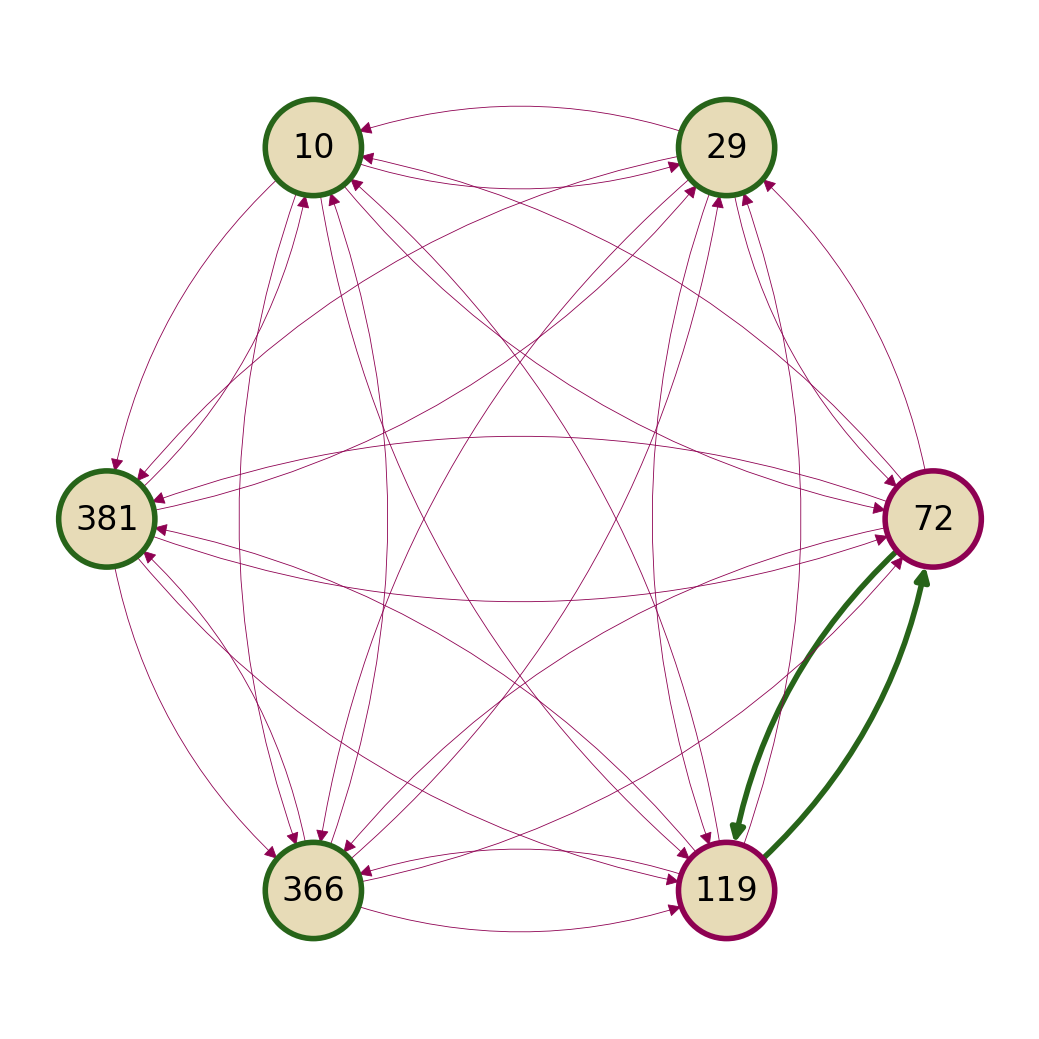

In [7]:
visualise_ideal(CYSTEINES)

In [8]:
prec_probs = compute_prec_probabilities(fragment_matches)
prec_probs[:3]

[0.0012270158607891881, 0.0012270158607891881, 0.0012270158607891881]

In [37]:
pos, neg, alk = calculate_scores(
    fragment_matches,
    prec_probs,
    CYSTEINES,
    weight=lambda m: (1 / (m["precursor"].to_dict()["prec_max_mc_count"] + 0.0001)),
)

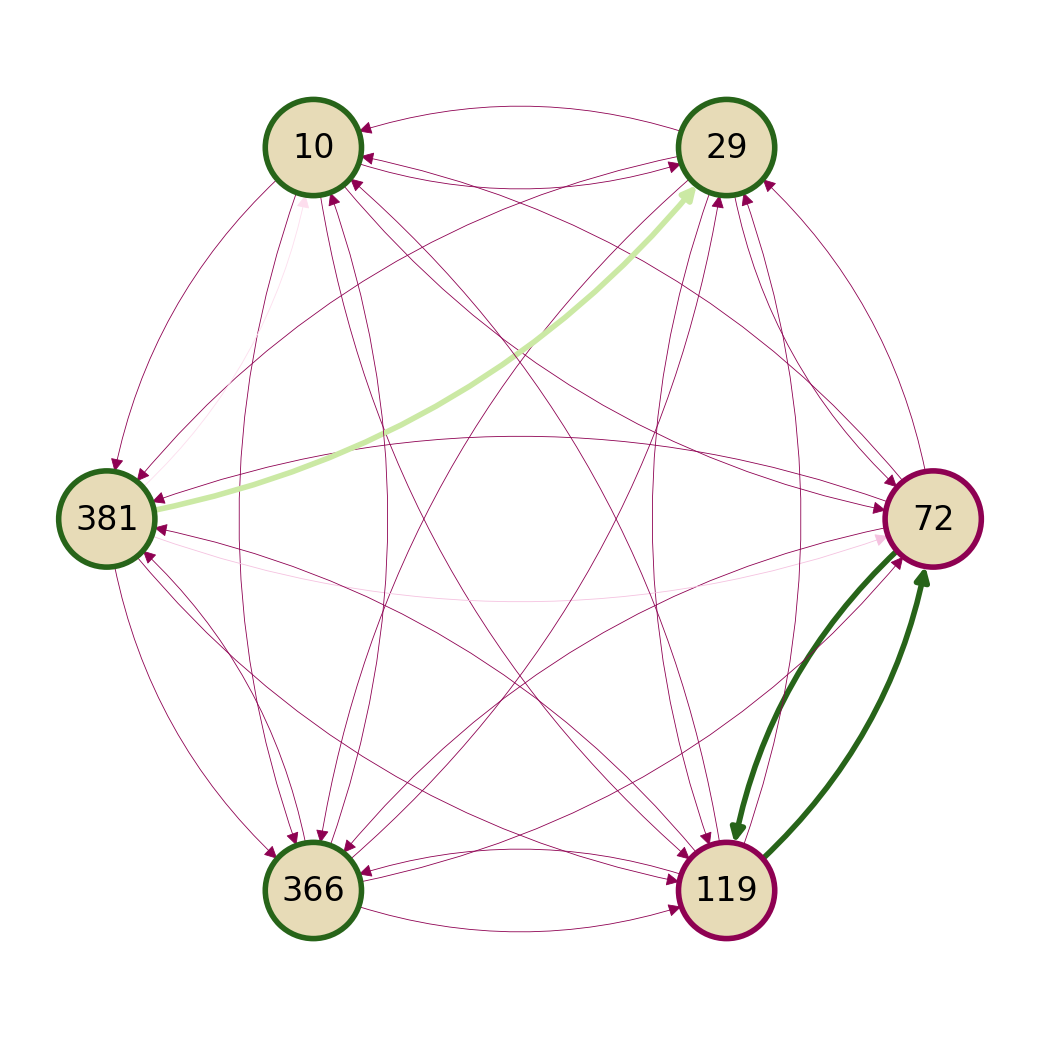

In [38]:
visualise(CYSTEINES, pos, neg, alk)

In [34]:
for pm in precursor_matches:
    p: Precursor = pm["precursor"]
    if any(b <= 72 < e for b, e in p.residue_ranges) and any(
        b <= 119 < e for b, e in p.residue_ranges
    ):
        print(p.to_dict())

{'prec_sequence': 'GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAKDSTR+LPGFGDSIEAQCGTSVNVHSSLR+YPILPEYLQCVKELYR', 'prec_segment_count': 3, 'prec_tryptide_ranges': [(0, 4), (7, 8), (10, 12)], 'prec_residue_ranges': [(0, 50), (61, 84), (110, 126)], 'prec_max_mc_count': 3, 'prec_mc': [3, 0, 1], 'prec_cys_bond_count': 2, 'prec_mass': 9926.86418214936, 'prec_mz': 1985.372836429872, 'prec_error': 1.274856718039514, 'prec_alkylation_count': 0, 'prec_mods': ['Met Oxidation', 'Met Oxidation']}
{'prec_sequence': 'GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAKDSTR+FDKLPGFGDSIEAQCGTSVNVHSSLR+YPILPEYLQCVKELYRGGLEPINFQTAADQAR', 'prec_segment_count': 3, 'prec_tryptide_ranges': [(0, 4), (6, 8), (10, 13)], 'prec_residue_ranges': [(0, 50), (58, 84), (110, 142)], 'prec_max_mc_count': 3, 'prec_mc': [3, 1, 2], 'prec_cys_bond_count': 2, 'prec_mass': 11986.884309699128, 'prec_mz': 1997.8140516165213, 'prec_error': 6.278999173459721, 'prec_alkylation_count': 0, 'prec_mods': ['Met Oxidation', 'Met Oxidation']}


In [91]:

[str(b) for b in TRUE_BONDS]

['(52, 61)',
 '(74, 90)',
 '(89, 100)',
 '(122, 167)',
 '(166, 175)',
 '(198, 244)',
 '(243, 251)',
 '(263, 277)',
 '(276, 287)',
 '(314, 359)',
 '(358, 367)',
 '(390, 436)',
 '(435, 446)',
 '(459, 475)',
 '(474, 485)',
 '(512, 557)',
 '(556, 565)']

In [ ]:
ideal = [
    ((52, 61), True),
    ((61, 52), True),
    ((74, 90), True),
    ((89, 100), True),
    ((90, 74), True),
    ((100, 89), True),
    ((122, 167), True),
    ((166, 175), True),
    ((167, 122), True),
    ((175, 166), True),
    ((198, 244), True),
    ((243, 251), True),
    ((244, 198), True),
    ((251, 243), True),
    ((263, 277), True),
    ((276, 287), True),
    ((277, 263), True),
    ((287, 276), True),
    ((314, 359), True),
    ((358, 367), True),
    ((359, 314), True),
    ((367, 358), True),
    ((390, 436), True),
    ((435, 446), True),
    ((436, 390), True),
    ((446, 435), True),
    ((459, 475), True),
    ((474, 485), True),
    ((475, 459), True),
    ((485, 474), True),
    ((512, 557), True),
    ((556, 565), True),
    ((557, 512), True),
    ((565, 556), True),
]